# Import and Setup

### Import useful libraries for analysis

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st

### Choose version of Discovery Potential Calculation to run

In [2]:
version = 44
Livetime = 10.0

In [3]:
SensPath = '/p/lustre1/jamil1/'
SensPath = '/gpfs/slac/staas/fs1/g/exo/exo_data8/exo_data/users/akojamil/nexo/'

In [4]:
import pandas as pd 
dp_csv = pd.read_csv(SensPath+'sensitivity/work/SensitivityPaper2020_scripts/DiscoveryPotential/dp_versions.csv', 
                     usecols=[0,1,2,3,4,8])
dp_version = dp_csv[dp_csv['Name'].str.contains("Version %d" % version)]

In [5]:
PlotDir = SensPath+'sensitivity/work/SensitivityPaper2020_scripts/DiscoveryPotential/plots/version%d/' % version
DataDir = str(dp_version['Data Directory'].to_numpy()[0])+'/h5/'

if not os.path.isdir(PlotDir):
    os.makedirs(PlotDir)

### Import the nEXO sensitivity classes

In [6]:
import sys
sys.path.append(SensPath+'sensitivity/modules')

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

### Adjusting plots

In [7]:
from matplotlib import pyplot as plt
plt.style.use('../PaperPlots/sensitivity.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Useful functions

This function sorts a list of strings in a natural way, i.e. '10' comes after '1'. 

In [8]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

This function uses the isotopic abundance of Xe-136 and Xe-134 and their respective molar masses to calculate the number of Xe-136 atoms in any given fiducial mass. Combined with a predetermined signal efficiency it returns the expected lower limit on the half-life.

In [9]:
mmass_xe136 = 135.907214 # in gram/mol 
mmass_xe134 = 133.905393 # in gram/mol 
Avogadro = 6.02214076E23 # in 1/mol
bb0n_eff = 0.963
XeMass_fiducial = 3281.0*1000.0 # in gram
frac_136 = 0.9
frac_134 = 0.1

def GetLivetime(Num, Livetime):
    NXenon136 = (XeMass_fiducial * Avogadro * frac_136) / (frac_136 * mmass_xe136 + frac_134  * mmass_xe134)
    return bb0n_eff * NXenon136 * Livetime  * np.log(2.0) / Num

def GetSignalCount(Halflife, Livetime): 
    NXenon136 = (XeMass_fiducial * Avogadro * frac_136) / (frac_136 * mmass_xe136 + frac_134  * mmass_xe134)
    return bb0n_eff * NXenon136 * Livetime  * np.log(2.0) / Halflife

# Data Read-In
Define directory from where to read in the data and select only HDF5 files.

In [10]:
AllFiles = os.listdir(DataDir)
H5Files = [filename for filename in AllFiles if filename.endswith('.h5')]
print('Number of files {}'.format(len(H5Files)))

Number of files 10250


For all HDF5 files that were found in the above directory we want to sort them by simulated Scaling of the experiment and mean number of signal counts that were used in the toy datasets. The filename follows this naming convention: DiscoverPotential_bb0n_[num]ct_[Scaling]yrs.h5 where num is the mean number of signal counts in the toy datasets and Scaling is the simulated Scaling of nEXO.

In [11]:
BkgScaling = [10.0]
Tags = {}
for ii,Scaling in enumerate(BkgScaling):
    Tags[Scaling] = natural_sort(np.unique(['_'.join(x.split('_')[:3])
                                 +'_10.0yrs_g%.1f' % Scaling for x in H5Files if 'g%.1f' % Scaling in x]))
print(Tags)

{10.0: ['DiscoveryPotential_bb0n_0ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_1ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_2ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_4ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_6ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_8ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_10ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_12ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_14ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_16ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_18ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_20ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_22ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_24ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_26ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_28ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_30ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_32ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_34ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_36ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_38ct_10.0yrs_g10.0', 'DiscoveryPotential_bb0n_40ct_10

Sorting by mean number of signal counts and Scaling we read in the data into a python dictionary of pandas DataFrames. 

In [12]:
dfdict = {}

for Scaling in BkgScaling:
    print('='*15 + '   {} scaling of backgrounds   '.format(Scaling) + '='*15)
    dfdict[Scaling] = {}
    for category in Tags[Scaling]:
        df_list = [pd.read_hdf(DataDir+filename) for filename in H5Files if category in filename]
        print('Number of file for {}: {}'.format(category, len(df_list)))
        dfdict[Scaling][category] = pd.concat(df_list,ignore_index=True)
        

===============   10.0 scaling of backgrounds   ===============
Number of file for DiscoveryPotential_bb0n_0ct_10.0yrs_g10.0: 1000
Number of file for DiscoveryPotential_bb0n_1ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_2ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_4ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_6ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_8ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_10ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_12ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_14ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_16ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_18ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_20ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_22ct_10.0yrs_g10.0: 50
Number of file for DiscoveryPotential_bb0n_24ct_10.0yrs_g10.0: 50
Number of file f

# Selection Cut
Prevent datasets from entering the distribution of test statistics for which either one of the hypothesis test fits with a fixed number of bb0n counts or the global best fit did not converge. For each tag the percentage of converged datasets will be printed.

In [13]:
maskdict = {}
for Scaling in BkgScaling:
    print('='*15 + '   {} scaling for backgrounds  '.format(Scaling) + '='*15)
    maskdict[Scaling] = {} 
    for key, df in dfdict[Scaling].items():
        shape_error = []
        print('Running {}'.format(key))
        good_fit_mask = []
        for index,row in df.iterrows():
            if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1 \
                or np.sum(row['fixed_fit_converged']) < len(row['num_signal']) \
                or not row['best_fit_covar'] \
                or not row['best_fit_converged'] \
                or np.min(row['lambda'])<-0.1:
                good_fit_mask.append(False)
            else:
                good_fit_mask.append(True)

        maskdict[Scaling][key] = np.array(good_fit_mask)
        print('-> Convergence fraction: {:3.4}'.format(np.sum(maskdict[Scaling][key])/len(maskdict[Scaling][key])))

===============   10.0 scaling for backgrounds  ===============
Running DiscoveryPotential_bb0n_0ct_10.0yrs_g10.0
-> Convergence fraction: 0.9947
Running DiscoveryPotential_bb0n_1ct_10.0yrs_g10.0
-> Convergence fraction: 0.9934
Running DiscoveryPotential_bb0n_2ct_10.0yrs_g10.0
-> Convergence fraction: 0.9938
Running DiscoveryPotential_bb0n_4ct_10.0yrs_g10.0
-> Convergence fraction: 0.9918
Running DiscoveryPotential_bb0n_6ct_10.0yrs_g10.0
-> Convergence fraction: 0.989
Running DiscoveryPotential_bb0n_8ct_10.0yrs_g10.0
-> Convergence fraction: 0.988
Running DiscoveryPotential_bb0n_10ct_10.0yrs_g10.0
-> Convergence fraction: 0.9852
Running DiscoveryPotential_bb0n_12ct_10.0yrs_g10.0
-> Convergence fraction: 0.983
Running DiscoveryPotential_bb0n_14ct_10.0yrs_g10.0
-> Convergence fraction: 0.9834
Running DiscoveryPotential_bb0n_16ct_10.0yrs_g10.0
-> Convergence fraction: 0.9826
Running DiscoveryPotential_bb0n_18ct_10.0yrs_g10.0
-> Convergence fraction: 0.9802
Running DiscoveryPotential_bb0n_

# Analysis
Here we go through all the toy datasets that have passed the above selection cut and record the value of the test statistic for which the mean number of signal events in the toy dataset is 0, hence we look at the first element in the $\lambda$ curve. Since $\lambda = 2\cdot \Delta \mathrm{NNL}$ we will divide the test statistic value in the data by 2 to compute the signficance based on the $\Delta \mathrm{NNL}$ distribution. 

In [14]:
DeltaNLL = {}
import matplotlib.patches as mpatches
for Scaling in BkgScaling: 
    DeltaNLL[Scaling] = {} 
    for key, df in dfdict[Scaling].items():
        DeltaNLL[Scaling][key] = []
        for ii,(x,y) in enumerate(zip(dfdict[Scaling][key]['num_signal'].loc[maskdict[Scaling][key]],
                                      dfdict[Scaling][key]['lambda'].loc[maskdict[Scaling][key]])):
            DeltaNLL[Scaling][key].append(y[0]/2.0)

The below cell does a couple of things: 
- it plots the distribution of $\Delta \mathrm{NNL}$ for all the toy datasets in which the mean number of signal in the toy dataset is 0 (shown as gray shaded histogram). This will be the distribution of our null hypothesis based on which we will compute the p-value of the alternative hypothesis for which the mean number of signal counts in the toy dataset is greater than 0.
- the distribution of $\Delta \mathrm{NNL}$ for the alternative hypotheses are plotted as colored histograms. 
- The median of each of those distributions is computed and plotted in the same color as vertical solid lines. 
- Given the median we calculate its p-value based on the null distribution (grey histogram), i.e. what is the median probability of getting a result as extreme or more extreme as this alternative hypothesis assuming the null hypothesis is true. 
- This will give a list of pairs of p-value and 

0 DiscoveryPotential_bb0n_1ct_10.0yrs_g10.0 9.014766910819816e-05
1 DiscoveryPotential_bb0n_2ct_10.0yrs_g10.0 0.020786277245287366
2 DiscoveryPotential_bb0n_4ct_10.0yrs_g10.0 0.27969345712028204
3 DiscoveryPotential_bb0n_6ct_10.0yrs_g10.0 0.6292878880589505
4 DiscoveryPotential_bb0n_8ct_10.0yrs_g10.0 1.1450095138309895
5 DiscoveryPotential_bb0n_10ct_10.0yrs_g10.0 1.8016250795711117
6 DiscoveryPotential_bb0n_12ct_10.0yrs_g10.0 2.409974397766205
7 DiscoveryPotential_bb0n_14ct_10.0yrs_g10.0 3.192645302254844
8 DiscoveryPotential_bb0n_16ct_10.0yrs_g10.0 3.9449896633245505
9 DiscoveryPotential_bb0n_18ct_10.0yrs_g10.0 4.885715786901014
10 DiscoveryPotential_bb0n_20ct_10.0yrs_g10.0 5.732671160843498
11 DiscoveryPotential_bb0n_22ct_10.0yrs_g10.0 6.7302133407846885
12 DiscoveryPotential_bb0n_24ct_10.0yrs_g10.0 7.796227938886033
13 DiscoveryPotential_bb0n_26ct_10.0yrs_g10.0 8.918125621460481
14 DiscoveryPotential_bb0n_28ct_10.0yrs_g10.0 10.022740301702221
15 DiscoveryPotential_bb0n_30ct_10.0yrs_

IndexError: list index out of range

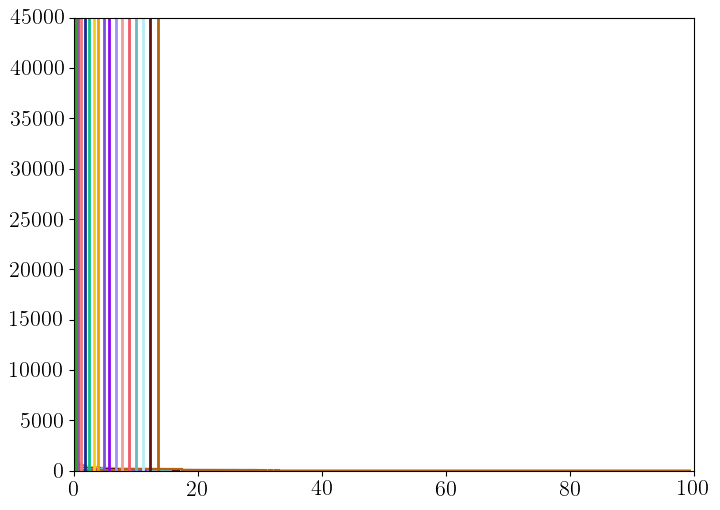

In [15]:
hist = {}
medians = {}
cl_68_low = {}
cl_68_high = {}
medians = {}
for Scaling in BkgScaling:
    fig = plt.figure(figsize=(8,6))
    
    # get number of counts from tag name
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Scaling].keys())][1:] 
    FoundNull = np.char.find(list(DeltaNLL[Scaling].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Scaling].keys())[NullIndex]
    
    hist[NullSet] = plt.hist(DeltaNLL[Scaling][NullSet], 
                            bins=np.arange(0,100,0.1), 
                            label=r'No $0\nu\beta\beta$', 
                            histtype='stepfilled', 
                            color='grey', 
                            alpha=0.5)

    medians[Scaling] = []
    cl_68_low[Scaling] = []
    cl_68_high[Scaling] = []
    for ii,key in enumerate(list(DeltaNLL[Scaling].keys())[1:]):
        hist[key] = plt.hist(DeltaNLL[Scaling][key], 
                            bins=np.arange(0,100,0.5), 
                            label=r'$\langle0\nu\beta\beta\rangle$ = %s' % label[ii], 
                            histtype='step', 
                            color=colors[ii],
                            lw=1.5)
        median = np.median(DeltaNLL[Scaling][key])
        print(ii, key, median)
        plt.axvline(x=median, ymin=0, ymax=1000, ls='-', color=colors[ii])
        medians[Scaling].append(median)
        sortedpdf = sorted(DeltaNLL[Scaling][key])
        median_index = np.where(np.abs(sortedpdf-median) == np.min(np.abs(sortedpdf-median)))[0][0]
        cl_68_low[Scaling].append(sortedpdf[median_index-int(0.34*len(sortedpdf)) ])
        cl_68_high[Scaling].append(sortedpdf[median_index+int(0.34*len(sortedpdf)) ] )
        

    xmax = 20
    plt.xlim(0,xmax)
    plt.xticks(np.arange(0,xmax+0.1,xmax/10.0))
    plt.yscale('log')
    plt.xlabel(r'Significance of $0\nu\beta\beta$ signal, $\Delta$NNL', fontsize=16)
    plt.ylabel('Counts/bin', fontsize=16)
    plt.legend(loc='upper right', fontsize=10)

    for ii in [1,2,3]:
        index = int(np.ceil(st.norm.cdf(ii)*len(DeltaNLL[Scaling][NullSet])))
        print(ii, index)
        signif = sorted(DeltaNLL[Scaling][NullSet])[index]
        print(ii, index, st.norm.cdf(ii), signif)
        plt.axvline(x=signif, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(signif+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (ii),rotation=90, color='grey')

    # Significance assuming Wilks' theorem for sigma > 3
    # see slide 11 in 
    # https://indico.cern.ch/event/162087/contributions/235303/attachments/189340/265790/cowan_cargese_2.pdf
    for sigma in [4]:
        plt.axvline(x=sigma**2/2.0, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(sigma**2/2.0+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (sigma),rotation=90, color='grey')


    plt.savefig(PlotDir+'null_hypothesis_%.2fscale_%s.png' % (Scaling,version), bbox_inches='tight', dpi=300)

In [ ]:
sigma = {}
sigma_68CL_low = {}
sigma_68CL_high = {}
Cut = {}
XInterp = {}
Interpolation = {}

def GetSigma(val, dist):
    diff_abs = np.abs(dist - val)
    nll_val = np.min(diff_abs)
    cut = np.where(diff_abs == nll_val)[0][0]
    sign = st.norm.ppf((cut+1)/len(sorted_nll))
    if np.isinf(sign) or sign > 3.5: 
        sign = np.sqrt(2 * val)
    return sign

for Scaling in BkgScaling:
    # get number of counts from tag name
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Scaling].keys())][1:]
    FoundNull = np.char.find(list(DeltaNLL[Scaling].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Scaling].keys())[NullIndex]
    
    sorted_nll = sorted(DeltaNLL[Scaling][NullSet])
    sigma[Scaling] = []
    sigma_68CL_low[Scaling] = []
    sigma_68CL_high[Scaling] = []
    for ii,key in enumerate(list(DeltaNLL[Scaling].keys())[1:]):
        diff_abs = np.abs(sorted_nll - medians[Scaling][ii])
        nll_val = np.min(diff_abs)
        cut = np.where(diff_abs == nll_val)[0][0]

        
        sigma[Scaling].append(GetSigma(medians[Scaling][ii], sorted_nll))
        sigma_68CL_low[Scaling].append(GetSigma(cl_68_low[Scaling][ii], sorted_nll))
        sigma_68CL_high[Scaling].append(GetSigma(cl_68_high[Scaling][ii], sorted_nll))

        # sigma[Scaling].append(st.norm.ppf((cut+1)/len(sorted_nll)))    
    
    XInterp[Scaling] = np.linspace(int(label[0]),int(label[-1]),1000)
    Interpolation[Scaling] = np.interp(XInterp[Scaling], np.array(label).astype(int), sigma[Scaling])
    Diff = np.abs(Interpolation[Scaling] - 3.0)
    Cut[Scaling] = np.where(Diff == np.min(Diff))[0][0]

In [ ]:
for Scaling in BkgScaling:

    def GetT(x):
        return GetLivetime(x,Livetime)
    def GetN(x):
        return GetSignalCount(x,Livetime)
    
    # get number of counts from tag name
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Scaling].keys())][1:]

    fig, ax = plt.subplots(figsize=(9,6))
    ax.fill_between(GetT(np.array(label).astype(int)), sigma_68CL_low[Scaling], sigma_68CL_high[Scaling], 
                    color='grey', alpha=0.5)
    ax.plot(GetT(XInterp[Scaling]), Interpolation[Scaling], label='', ls=':', color='k')
    ax.scatter(GetT(np.array(label).astype(int)), sigma[Scaling], color='k', marker='.', s=80)
    
    Cut_5sigma = np.where( np.abs(Interpolation[Scaling]-5) == np.min(np.abs(Interpolation[Scaling]-5)) )
    ax.hlines(Interpolation[Scaling][Cut_5sigma], xmin=1e27, xmax=GetT(XInterp[Scaling][Cut_5sigma]), 
              color=colors[1], ls='--')
    ax.vlines(GetT(XInterp[Scaling][Cut_5sigma]), ymin=0, ymax=Interpolation[Scaling][Cut_5sigma], 
              color=colors[1], ls='--', label='Half-life at 5$\sigma$ Discovery Significance')

    print(np.round(XInterp[Scaling][Cut[Scaling]], 2))
    ax.hlines(3, xmin=0, xmax=GetT(XInterp[Scaling][Cut[Scaling]]), color=colors[0], ls='--')
    ax.vlines(GetT(XInterp[Scaling][Cut[Scaling]]), ymin=0, ymax=3, color=colors[0], ls='--', 
              label='Half-life at 3$\sigma$ Discovery Significance')

    Cut_10to28 = np.where( np.abs(GetT(XInterp[Scaling])-1E28) == np.min(np.abs(GetT(XInterp[Scaling])-1E28)) )
    ax.hlines(Interpolation[Scaling][Cut_10to28], xmin=1e20, xmax=1e28, color=colors[2], ls='--')
    ax.vlines(1E28, ymin=0, ymax=Interpolation[Scaling][Cut_10to28], color=colors[2], ls='--', 
              label='Discovery Significance at $10^{28}$ yr')

    ax.text(x=GetT(XInterp[Scaling][Cut[Scaling]])*1.2, y=3.2, 
            s=r'$T_{1/2}=$%.2e' % GetLivetime(XInterp[Scaling][Cut[Scaling]], Livetime), 
            color=colors[0], fontsize=12, bbox=dict(facecolor='w', edgecolor=colors[0], alpha=1))
    ax.text(x=GetT(XInterp[Scaling][Cut_5sigma])*1.2, y=5.2, 
            s=r'$T_{1/2}=$%.2e' % GetT(XInterp[Scaling][Cut_5sigma]), color=colors[1], 
            fontsize=12, bbox=dict(facecolor='w', edgecolor=colors[1], alpha=1))
    ax.text(x=1E28*1.2, y=Interpolation[Scaling][Cut_10to28]+0.2, 
            s=r'$\sigma=$%.2f' % Interpolation[Scaling][Cut_10to28], color=colors[2], 
            fontsize=12, bbox=dict(facecolor='w', edgecolor=colors[2], alpha=1))
    

    ax.set_xscale('log')
    ax.set_xlim(1e25, 1e29)
    ax.set_ylim(0,6)
    ax.set_xlabel('Half-life [yr]')
    ax.set_ylabel(r'Significance $\sigma$ ', fontsize=16)
    ax.legend(loc='upper right', fontsize=11)
    
    secax = ax.secondary_xaxis('top', functions=(GetN, GetT))
    secax.set_xlabel(r'Mean number of $0\nu\beta\beta$ events', fontsize=16)

    plt.savefig(PlotDir+'sigma_vs_bb0n_%.2fscale_%s.pdf' % (Scaling,version), bbox_inches='tight', dpi=300)